$MA(1)$

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Importamos tqdm

# --- 0. Configuración Inicial y Parámetros ---

# Parámetros del modelo MA(1) 'verdadero'
PHI_TRUE = 0.7      # Valor real de phi (coeficiente MA(1))
SIGMA_TRUE = 1      # Valor real de sigma (desviación estándar del error)

# Parámetros de la serie maestra para el bootstrap
LONG_SERIES_LENGTH = 1000      # Longitud de la serie original de donde se extraen los bloques

# Parámetros para el Block Bootstrap y la longitud de las series para los modelos
SERIES_LENGTH_FOR_MODELS = 10   # NUEVO: Longitud de cada serie (real o falsa) que verá el discriminador
BLOCK_SIZE = 10                 # Tamaño de los bloques para el bootstrap. Debería ser > SERIES_LENGTH_FOR_MODELS.

NUM_SAMPLES_PER_STEP = 1000     # NUEVO: Número de series (reales o falsas) a usar en cada paso del entrenamiento

# El número de 'series' reales (bootstrapped) y simuladas por el generador
N_ACTUAL = NUM_SAMPLES_PER_STEP
M_SIMULATED = NUM_SAMPLES_PER_STEP

# Parámetros de la LSTM del Discriminador
LSTM_INPUT_DIM = 1
LSTM_HIDDEN_DIM = 50
LSTM_NUM_LAYERS = 1
DISCRIMINATOR_DROPOUT = 0.2

# Hiperparámetros de entrenamiento
NUM_GENERATOR_STEPS = 10000
NUM_EPOCHS_DISCRIMINATOR = 1
BATCH_SIZE = 64

LR_DISCRIMINATOR = 0.0005
LR_GENERATOR_INITIAL = 0.005

# Parámetros para el criterio de parada del Generador
TOLERANCE_PARAMS = 1e-3
PATIENCE = 50

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Determinar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


## 1. Función de Generación de MA(1) y Block Bootstrap


def generate_ma1_series_single(phi, sigma, T, initial_error=0.0):
    """
    Genera una única serie temporal de un proceso MA(1).
    Los errores son N(0, sigma^2).
    Se asume mu = 0.
    """
    series = torch.zeros(T, dtype=torch.float32).to(device)
    errors = torch.randn(T, dtype=torch.float32).to(device) * sigma # N(0, sigma^2)

    epsilon_prev = initial_error

    for t in range(T):
        if t == 0:
            series[t] = errors[t] + phi * epsilon_prev
        else:
            series[t] = errors[t] + phi * errors[t-1]
    return series

def block_bootstrap_series(original_series: torch.Tensor, block_size: int, target_length: int, num_series_to_generate: int):
    """
    Realiza un block bootstrap para generar múltiples series temporales.

    Args:
        original_series (torch.Tensor): La serie temporal 1D de la que extraer bloques.
        block_size (int): El tamaño de cada bloque a remuestrear.
        target_length (int): La longitud deseada para cada serie bootstrapped generada.
        num_series_to_generate (int): Cuántas series bootstrapped completas generar.

    Returns:
        torch.Tensor: Un tensor de forma (num_series_to_generate, target_length),
                      con las series bootstrapped.
    """
    n_original = original_series.size(0)

    if n_original < block_size:
        raise ValueError(f"La serie original ({n_original}) es más corta que el tamaño del bloque ({block_size}).")
    if target_length < block_size:
        # Esto podría ser una advertencia o no dependiendo del uso.
        # En este contexto, cada "block" es una sub-muestra que se concatena
        # hasta formar una serie de `target_length`.
        pass

    bootstrapped_data_list = []

    num_possible_blocks = n_original - block_size + 1
    if num_possible_blocks <= 0:
        raise ValueError(f"No hay bloques posibles con el tamaño {block_size} de la serie original de longitud {n_original}.")

    num_blocks_needed_per_series = int(np.ceil(target_length / block_size))

    for _ in range(num_series_to_generate):
        current_bootstrapped_series = []
        for _ in range(num_blocks_needed_per_series):
            start_idx = torch.randint(0, num_possible_blocks, (1,)).item()
            block = original_series[start_idx : start_idx + block_size]
            current_bootstrapped_series.append(block)

        full_bootstrapped_series = torch.cat(current_bootstrapped_series)[:target_length]
        bootstrapped_data_list.append(full_bootstrapped_series)

    return torch.stack(bootstrapped_data_list).to(original_series.device)


print(f"Generando una única serie temporal 'maestra' de longitud {LONG_SERIES_LENGTH} para el Block Bootstrap...")
actual_long_series_master = generate_ma1_series_single(PHI_TRUE, SIGMA_TRUE, LONG_SERIES_LENGTH)



## 3. Definir el Modelo MA(1) del Generador


class MA1Generator(nn.Module):
    def __init__(self, initial_phi, initial_sigma, series_length, num_series):
        super(MA1Generator, self).__init__()
        self.log_sigma = nn.Parameter(torch.tensor(np.log(initial_sigma), dtype=torch.float32))
        self.phi = nn.Parameter(torch.tensor(initial_phi, dtype=torch.float32))
        self.series_length = series_length # Ahora es SERIES_LENGTH_FOR_MODELS
        self.num_series = num_series # Número de series a generar en cada forward pass

    def forward(self):
        current_sigma = torch.exp(self.log_sigma)

        shocks = torch.randn(self.num_series, self.series_length, dtype=torch.float32).to(self.phi.device) * current_sigma

        simulated_series_list = []

        epsilon_prev_batch = torch.zeros(self.num_series, dtype=torch.float32).to(self.phi.device)

        for t in range(self.series_length):
            current_epsilon = shocks[:, t]

            if t == 0:
                next_step = current_epsilon + self.phi * epsilon_prev_batch
            else:
                next_step = current_epsilon + self.phi * shocks[:, t-1]

            simulated_series_list.append(next_step.unsqueeze(1))

        simulated_data_stacked = torch.cat(simulated_series_list, dim=1).unsqueeze(-1) # (batch, series_length, 1)

        return simulated_data_stacked


## 4. Definir la Red LSTM del Discriminador

class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(LSTMDiscriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        last_hidden_state = hn[-1, :, :]

        output = self.fc(last_hidden_state)
        output = self.sigmoid(output)

        return output

# --- Inicialización de Modelos y Optimizadores ---
INITIAL_PHI_GEN = 0.5
INITIAL_SIGMA_GEN = 0.8

# El generador ahora usa SERIES_LENGTH_FOR_MODELS
generator = MA1Generator(INITIAL_PHI_GEN, INITIAL_SIGMA_GEN, SERIES_LENGTH_FOR_MODELS, M_SIMULATED).to(device)
# El discriminador también usa SERIES_LENGTH_FOR_MODELS para su tamaño de entrada
discriminator = LSTMDiscriminator(LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, DISCRIMINATOR_DROPOUT).to(device)

optimizer_d = optim.Adam(discriminator.parameters(), lr=LR_DISCRIMINATOR)
optimizer_g = optim.Adam(generator.parameters(), lr=LR_GENERATOR_INITIAL)

criterion_d = nn.BCELoss()

# Almacenar resultados para visualización
history = {
    'phi_est': [],
    'sigma_est': [],
    'd_loss': [],
    'g_loss': [],
    'd_sim_output_mean': []
}

# Variables para el criterio de parada
epochs_no_improve_gen = 0
min_change_gen = float('inf')
prev_phi = generator.phi.item()
prev_log_sigma = generator.log_sigma.item()


print("\n--- Starting Adversarial Training ---")

# Es buena práctica DESHABILITAR esto para el entrenamiento final por rendimiento
# torch.autograd.set_detect_anomaly(True)

pbar = tqdm(range(NUM_GENERATOR_STEPS), desc="Generator Steps")
for gen_step in pbar:
    # --- Generar un nuevo conjunto de datos reales usando Block Bootstrap en cada paso ---
    current_actual_data = block_bootstrap_series(
        actual_long_series_master,
        block_size=BLOCK_SIZE,
        target_length=SERIES_LENGTH_FOR_MODELS, # <- Usamos la nueva variable aquí
        num_series_to_generate=N_ACTUAL
    ).unsqueeze(-1)

    current_actual_data = current_actual_data.to(device)

    # --- Step 1: Generate simulated data for current phi_k ---
    simulated_data = generator().detach()

    # --- Step 2: Train the Discriminator until completion ---
    combined_data = torch.cat([current_actual_data, simulated_data], dim=0)
    labels = torch.cat([torch.ones(N_ACTUAL, 1), torch.zeros(M_SIMULATED, 1)], dim=0).to(device)

    dataset_d = torch.utils.data.TensorDataset(combined_data, labels)
    dataloader_d = torch.utils.data.DataLoader(dataset_d, batch_size=BATCH_SIZE, shuffle=True)

    discriminator_losses_this_step = []

    for d_epoch in range(NUM_EPOCHS_DISCRIMINATOR):
        epoch_d_loss = 0
        discriminator.train()
        for batch_data, batch_labels in dataloader_d:
            optimizer_d.zero_grad()
            d_output = discriminator(batch_data)
            loss_d = criterion_d(d_output, batch_labels)
            loss_d.backward()
            optimizer_d.step()
            epoch_d_loss += loss_d.item()

        discriminator_losses_this_step.append(epoch_d_loss / len(dataloader_d))

    avg_d_loss = np.mean(discriminator_losses_this_step)
    history['d_loss'].append(avg_d_loss)

    # --- Step 3: Update the Generator (phi and sigma parameters) ---
    generator.zero_grad()
    discriminator.train()
    simulated_data_for_gen_grad = generator()

    d_output_on_simulated = discriminator(simulated_data_for_gen_grad)

    mean_d_sim_output = d_output_on_simulated.mean().item()
    history['d_sim_output_mean'].append(mean_d_sim_output)

    loss_g = torch.mean(torch.log(1 - d_output_on_simulated))

    loss_g.backward()
    optimizer_g.step()

    history['g_loss'].append(loss_g.item())
    history['phi_est'].append(generator.phi.item())
    history['sigma_est'].append(torch.exp(generator.log_sigma).item())

    # --- Stop Criterion for the Generator ---
    current_phi = generator.phi.item()
    current_log_sigma = generator.log_sigma.item()

    change_phi = abs(current_phi - prev_phi)
    change_log_sigma = abs(current_log_sigma - prev_log_sigma)

    total_param_change = max(change_phi, change_log_sigma)

    if total_param_change < TOLERANCE_PARAMS:
        epochs_no_improve_gen += 1
    else:
        epochs_no_improve_gen = 0

    prev_phi = current_phi
    prev_log_sigma = current_log_sigma

    if epochs_no_improve_gen >= PATIENCE:
        tqdm.write(f"\nStop criterion reached: Generator parameters stable for {PATIENCE} steps.")
        break

    pbar.set_postfix(
        phi=f"{generator.phi.item():.4f}",
        sigma=f"{torch.exp(generator.log_sigma).item():.4f}",
        d_loss=f"{avg_d_loss:.4f}",
        g_loss=f"{loss_g.item():.4f}",
        d_sim=f"{mean_d_sim_output:.4f}",
        patience=f"{epochs_no_improve_gen}/{PATIENCE}"
    )

print("\n--- Training Finished ---")
print(f"Estimated Phi: {history['phi_est'][-1]:.4f} (True Value: {PHI_TRUE})")
print(f"Estimated Sigma: {history['sigma_est'][-1]:.4f} (True Value: {SIGMA_TRUE})")

# --- Configuración para visualización ---
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['phi_est'], label=r'Estimated $\phi$')
plt.axhline(y=PHI_TRUE, color='r', linestyle='--', label=r'True $\phi$')
plt.title(r'$\phi$ Estimation Over Generator Steps')
plt.xlabel('Generator Steps')
plt.ylabel(r'Estimated Value of $\phi$')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['sigma_est'], label=r'Estimated $\sigma$')
plt.axhline(y=SIGMA_TRUE, color='r', linestyle='--', label=r'True $\sigma$')
plt.title(r'$\sigma$ Estimation Over Generator Steps')
plt.xlabel('Generator Steps')
plt.ylabel(r'Estimated Value of $\sigma$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('estimacion_parametros_ma1_block_bootstrap_unified.png', dpi=300, bbox_inches='tight')
plt.show()

Usando dispositivo: cpu
Generando una única serie temporal 'maestra' de longitud 1000 para el Block Bootstrap...

--- Starting Adversarial Training ---


Generator Steps:   0%|          | 23/10000 [00:18<2:15:03,  1.23it/s, d_loss=0.5282, d_sim=0.3846, g_loss=-0.5483, patience=0/50, phi=0.6108, sigma=0.8942]


KeyboardInterrupt: 

$AR(1)$

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Importamos tqdm

# --- 0. Configuración Inicial y Parámetros ---

# Parámetros del modelo AR(1) 'verdadero'
THETA_TRUE = 0.7    # Valor real de theta
SIGMA_TRUE = 1      # Valor real de sigma (desviación estándar del error)

# Parámetros para la serie maestra de la que se extraen bloques
LONG_SERIES_LENGTH = 1000      # Longitud de la serie original de la que se extraen los bloques

# Parámetros para la longitud de las series que ven los modelos (Discriminador y Generador)
# Esta será la longitud de la "ventana" o "bloque" final que se usa en el entrenamiento.
SERIES_LENGTH_FOR_MODELS = 5   # Longitud de cada serie (real o falsa) que verá el discriminador.

# Parámetros del Block Bootstrap
# BLOCK_SIZE debería ser idealmente >= SERIES_LENGTH_FOR_MODELS para capturar la estructura
# de dependencia completa de una serie si solo se usa un bloque.
# Si BLOCK_SIZE < SERIES_LENGTH_FOR_MODELS, se concatenarán varios bloques pequeños.
BLOCK_SIZE = 5                # Tamaño de los bloques que se remuestrean de LONG_SERIES_LENGTH.

NUM_SAMPLES_PER_STEP = 1000     # Número de series (reales o falsas) a usar en cada paso del entrenamiento

# El número de 'series' reales (bootstrapped) y simuladas por el generador
N_ACTUAL = NUM_SAMPLES_PER_STEP
M_SIMULATED = NUM_SAMPLES_PER_STEP

# Parámetros de la LSTM del Discriminador
LSTM_INPUT_DIM = 1
LSTM_HIDDEN_DIM = 50
LSTM_NUM_LAYERS = 1
DISCRIMINATOR_DROPOUT = 0.2

# Hiperparámetros de entrenamiento
NUM_GENERATOR_STEPS = 10000
NUM_EPOCHS_DISCRIMINATOR = 1 # Aumentado para dar más tiempo al discriminador
BATCH_SIZE = 64

LR_DISCRIMINATOR = 0.0005
LR_GENERATOR_INITIAL = 0.005

# Parámetros para el criterio de parada del Generador
TOLERANCE_PARAMS = 1e-3
PATIENCE = 50 # Aumentado para dar más tiempo a la convergencia

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Determinar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


## 1. Funciones de Generación de AR(1) y Block Bootstrap

def generate_ar1_series_single(theta, sigma, T, initial_value=0.0):
    """
    Genera una única serie temporal de un proceso AR(1).
    Los errores son N(0, sigma^2).
    """
    series = torch.zeros(T, dtype=torch.float32).to(device)
    errors = torch.randn(T, dtype=torch.float32).to(device) * sigma # N(0, sigma^2)

    y_prev = initial_value

    for t in range(T):
        if t == 0:
            series[t] = theta * y_prev + errors[t]
        else:
            series[t] = theta * series[t-1] + errors[t]
    return series

def block_bootstrap_series(original_series: torch.Tensor, block_size: int, target_length: int, num_series_to_generate: int):
    """
    Realiza un block bootstrap para generar múltiples series temporales.

    Args:
        original_series (torch.Tensor): La serie temporal 1D de la que extraer bloques.
        block_size (int): El tamaño de cada bloque a remuestrear.
        target_length (int): La longitud deseada para cada serie bootstrapped generada.
        num_series_to_generate (int): Cuántas series bootstrapped completas generar.

    Returns:
        torch.Tensor: Un tensor de forma (num_series_to_generate, target_length),
                      con las series bootstrapped.
    """
    n_original = original_series.size(0)

    if n_original < block_size:
        raise ValueError(f"La serie original ({n_original}) es más corta que el tamaño del bloque ({block_size}).")

    bootstrapped_data_list = []

    num_possible_blocks = n_original - block_size + 1
    if num_possible_blocks <= 0:
        raise ValueError(f"No hay bloques posibles con el tamaño {block_size} de la serie original de longitud {n_original}.")

    num_blocks_needed_per_series = int(np.ceil(target_length / block_size))

    for _ in range(num_series_to_generate):
        current_bootstrapped_series = []
        for _ in range(num_blocks_needed_per_series):
            start_idx = torch.randint(0, num_possible_blocks, (1,)).item()
            block = original_series[start_idx : start_idx + block_size]
            current_bootstrapped_series.append(block)

        full_bootstrapped_series = torch.cat(current_bootstrapped_series)[:target_length]
        bootstrapped_data_list.append(full_bootstrapped_series)

    return torch.stack(bootstrapped_data_list).to(original_series.device)


print(f"Generando una única serie temporal 'maestra' de longitud {LONG_SERIES_LENGTH} para el Block Bootstrap...")
actual_long_series_master = generate_ar1_series_single(THETA_TRUE, SIGMA_TRUE, LONG_SERIES_LENGTH)



## 3. Definir el Modelo AR(1) del Generador


class AR1Generator(nn.Module):
    def __init__(self, initial_theta, initial_sigma, series_length, num_series):
        super(AR1Generator, self).__init__()
        self.log_sigma = nn.Parameter(torch.tensor(np.log(initial_sigma), dtype=torch.float32))
        self.theta = nn.Parameter(torch.tensor(initial_theta, dtype=torch.float32))
        self.series_length = series_length # Ahora es SERIES_LENGTH_FOR_MODELS
        self.num_series = num_series # Número de series a generar en cada forward pass

    def forward(self):
        current_sigma = torch.exp(self.log_sigma)

        shocks = torch.randn(self.num_series, self.series_length, dtype=torch.float32).to(self.theta.device)

        simulated_series_list = []
        y_prev_batch = torch.zeros(self.num_series, dtype=torch.float32).to(self.theta.device)

        # Calculate the first step (t=0)
        first_step = self.theta * y_prev_batch + current_sigma * shocks[:, 0]
        simulated_series_list.append(first_step.unsqueeze(1))

        for t in range(1, self.series_length): # Comenzar desde t=1 para AR(1)
            next_step = self.theta * simulated_series_list[-1].squeeze(1) + current_sigma * shocks[:, t]
            simulated_series_list.append(next_step.unsqueeze(1))

        simulated_data_stacked = torch.cat(simulated_series_list, dim=1).unsqueeze(-1) # (batch, series_length, 1)

        return simulated_data_stacked

## 4. Definir la Red LSTM del Discriminador


class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(LSTMDiscriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        last_hidden_state = hn[-1, :, :]

        output = self.fc(last_hidden_state)
        output = self.sigmoid(output)

        return output

# --- Inicialización de Modelos y Optimizadores ---
INITIAL_THETA_GEN = 0.5
INITIAL_SIGMA_GEN = 0.8

# El generador ahora usa SERIES_LENGTH_FOR_MODELS para la longitud de sus series
generator = AR1Generator(INITIAL_THETA_GEN, INITIAL_SIGMA_GEN, SERIES_LENGTH_FOR_MODELS, M_SIMULATED).to(device)
# El discriminador también usa SERIES_LENGTH_FOR_MODELS para su tamaño de entrada.
discriminator = LSTMDiscriminator(LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, DISCRIMINATOR_DROPOUT).to(device)

optimizer_d = optim.Adam(discriminator.parameters(), lr=LR_DISCRIMINATOR)
optimizer_g = optim.Adam(generator.parameters(), lr=LR_GENERATOR_INITIAL)

criterion_d = nn.BCELoss()

# Almacenar resultados para visualización
history = {
    'theta_est': [],
    'sigma_est': [],
    'd_loss': [],
    'g_loss': [],
    'd_sim_output_mean': []
}

# Variables para el criterio de parada
epochs_no_improve_gen = 0
min_change_gen = float('inf')
prev_theta = generator.theta.item()
prev_log_sigma = generator.log_sigma.item()


print("\n--- Starting Adversarial Training ---")

# Es buena práctica DESHABILITAR esto para el entrenamiento final por rendimiento
# torch.autograd.set_detect_anomaly(True)

pbar = tqdm(range(NUM_GENERATOR_STEPS), desc="Generator Steps")
for gen_step in pbar:
    # --- Generar un nuevo conjunto de datos reales usando Block Bootstrap en cada paso ---
    current_actual_data = block_bootstrap_series(
        actual_long_series_master,
        block_size=BLOCK_SIZE,
        target_length=SERIES_LENGTH_FOR_MODELS, # <- ¡Aquí se usa la longitud unificada!
        num_series_to_generate=N_ACTUAL
    ).unsqueeze(-1) # Añadir la dimensión de característica para el discriminador

    current_actual_data = current_actual_data.to(device)

    # --- Step 1: Generate simulated data for current theta_k ---
    simulated_data = generator().detach()

    # --- Step 2: Train the Discriminator until completion ---
    combined_data = torch.cat([current_actual_data, simulated_data], dim=0)
    labels = torch.cat([torch.ones(N_ACTUAL, 1), torch.zeros(M_SIMULATED, 1)], dim=0).to(device)

    dataset_d = torch.utils.data.TensorDataset(combined_data, labels)
    dataloader_d = torch.utils.data.DataLoader(dataset_d, batch_size=BATCH_SIZE, shuffle=True)

    discriminator_losses_this_step = []

    for d_epoch in range(NUM_EPOCHS_DISCRIMINATOR):
        epoch_d_loss = 0
        discriminator.train()
        for batch_data, batch_labels in dataloader_d:
            optimizer_d.zero_grad()
            d_output = discriminator(batch_data)
            loss_d = criterion_d(d_output, batch_labels)
            loss_d.backward()
            optimizer_d.step()
            epoch_d_loss += loss_d.item()

        discriminator_losses_this_step.append(epoch_d_loss / len(dataloader_d))

    avg_d_loss = np.mean(discriminator_losses_this_step)
    history['d_loss'].append(avg_d_loss)

    # --- Step 3: Update the Generator (theta and sigma parameters) ---
    generator.zero_grad()
    discriminator.train()
    simulated_data_for_gen_grad = generator()

    d_output_on_simulated = discriminator(simulated_data_for_gen_grad)

    mean_d_sim_output = d_output_on_simulated.mean().item()
    history['d_sim_output_mean'].append(mean_d_sim_output)

    loss_g = torch.mean(torch.log(1 - d_output_on_simulated))

    loss_g.backward()
    optimizer_g.step()

    history['g_loss'].append(loss_g.item())
    history['theta_est'].append(generator.theta.item())
    history['sigma_est'].append(torch.exp(generator.log_sigma).item())

    # --- Stop Criterion for the Generator ---
    current_theta = generator.theta.item()
    current_log_sigma = generator.log_sigma.item()

    change_theta = abs(current_theta - prev_theta)
    change_log_sigma = abs(current_log_sigma - prev_log_sigma)

    total_param_change = max(change_theta, change_log_sigma)

    if total_param_change < TOLERANCE_PARAMS:
        epochs_no_improve_gen += 1
    else:
        epochs_no_improve_gen = 0

    prev_theta = current_theta
    prev_log_sigma = current_log_sigma

    if epochs_no_improve_gen >= PATIENCE:
        tqdm.write(f"\nStop criterion reached: Generator parameters stable for {PATIENCE} steps.")
        break

    pbar.set_postfix(
        theta=f"{generator.theta.item():.4f}",
        sigma=f"{torch.exp(generator.log_sigma).item():.4f}",
        d_loss=f"{avg_d_loss:.4f}",
        g_loss=f"{loss_g.item():.4f}",
        d_sim=f"{mean_d_sim_output:.4f}",
        patience=f"{epochs_no_improve_gen}/{PATIENCE}"
    )

print("\n--- Training Finished ---")
print(f"Estimated Theta: {history['theta_est'][-1]:.4f} (True Value: {THETA_TRUE})")
print(f"Estimated Sigma: {history['sigma_est'][-1]:.4f} (True Value: {SIGMA_TRUE})")

# --- Configuración para visualización ---
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1) # Ahora solo 2 subplots para AR(1)
plt.plot(history['theta_est'], label=r'Estimated $\theta$')
plt.axhline(y=THETA_TRUE, color='r', linestyle='--', label=r'True $\theta$')
plt.title(r'$\theta$ Estimation Over Generator Steps')
plt.xlabel('Generator Steps')
plt.ylabel(r'Estimated Value of $\theta$')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['sigma_est'], label=r'Estimated $\sigma$')
plt.axhline(y=SIGMA_TRUE, color='r', linestyle='--', label=r'True $\sigma$')
plt.title(r'$\sigma$ Estimation Over Generator Steps')
plt.xlabel('Generator Steps')
plt.ylabel(r'Estimated Value of $\sigma$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('estimacion_parametros_ar1_block_bootstrap_unified.png', dpi=300, bbox_inches='tight')
plt.show()

$AR(2)$

Usando dispositivo: cpu
Generando una única serie temporal 'maestra' de longitud 1000 para el Block Bootstrap...

--- Starting Adversarial Training ---


Generator Steps:   5%|▍         | 478/10000 [02:02<40:31,  3.92it/s, d_loss=0.6559, d_sim=0.4776, g_loss=-0.6725, patience=39/40, sigma=1.0129, theta1=0.4514, theta2=-0.1892]



Stop criterion reached: Generator parameters stable for 40 steps.

--- Training Finished ---
Estimated Theta1: 0.4512 (True Value: 0.4)
Estimated Theta2: -0.1889 (True Value: -0.2)
Estimated Sigma: 1.0127 (True Value: 1)


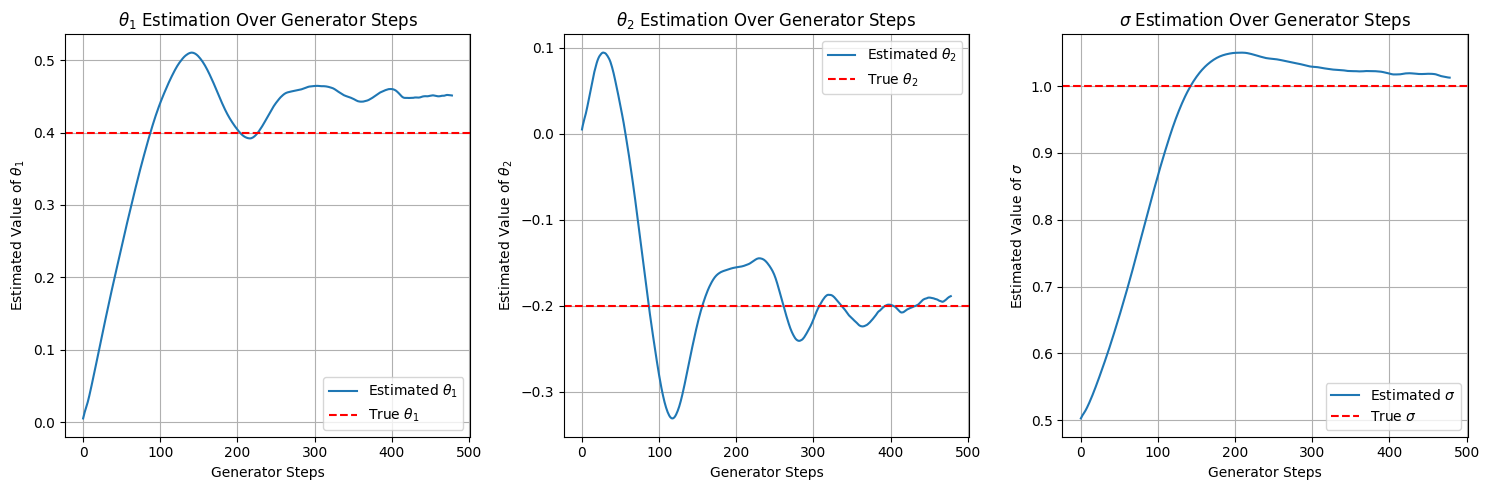

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Importamos tqdm

# --- 0. Configuración Inicial y Parámetros ---

# Parámetros del modelo AR(2) 'verdadero'
THETA1_TRUE = 0.4    # Valor real de theta1
THETA2_TRUE = -0.2   # Valor real de theta2 para AR(2)
SIGMA_TRUE = 1       # Valor real de sigma (desviación estándar del error)

# Parámetros para la serie maestra de la que se extraen bloques
LONG_SERIES_LENGTH = 1000      # Longitud de la serie original de la que se extraen los bloques

# Parámetros para la longitud de las series que ven los modelos (Discriminador y Generador)
# Esta será la longitud de la "ventana" o "bloque" final que se usa en el entrenamiento.
SERIES_LENGTH_FOR_MODELS = 5  # Longitud de cada serie (real o falsa) que verá el discriminador.

# Parámetros del Block Bootstrap
# BLOCK_SIZE debería ser idealmente >= SERIES_LENGTH_FOR_MODELS para capturar la estructura
# de dependencia completa de una serie si solo se usa un bloque.
# Si BLOCK_SIZE < SERIES_LENGTH_FOR_MODELS, se concatenarán varios bloques pequeños.
BLOCK_SIZE = 5                # Tamaño de los bloques que se remuestrean de LONG_SERIES_LENGTH.

NUM_SAMPLES_PER_STEP = 1000     # Número de series (reales o falsas) a usar en cada paso del entrenamiento

# El número de 'series' reales (bootstrapped) y simuladas por el generador
N_ACTUAL = NUM_SAMPLES_PER_STEP
M_SIMULATED = N_ACTUAL

# Parámetros de la LSTM del Discriminador
LSTM_INPUT_DIM = 1
LSTM_HIDDEN_DIM = 50
LSTM_NUM_LAYERS = 1
DISCRIMINATOR_DROPOUT = 0.2

# Hiperparámetros de entrenamiento
NUM_GENERATOR_STEPS = 10000
NUM_EPOCHS_DISCRIMINATOR = 1
BATCH_SIZE = 64

LR_DISCRIMINATOR = 0.0005
LR_GENERATOR_INITIAL = 0.005

# Parámetros para el criterio de parada del Generador
TOLERANCE_PARAMS = 1e-3
PATIENCE = 40

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# Determinar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


## 1. Funciones de Generación de AR(2) y Block Bootstrap

def generate_ar2_series_single(theta1, theta2, sigma, T, initial_value_prev1=0.0, initial_value_prev2=0.0):
    """
    Genera una única serie temporal de un proceso AR(2).
    Los errores son N(0, sigma^2).
    """
    series = torch.zeros(T, dtype=torch.float32).to(device)
    errors = torch.randn(T, dtype=torch.float32).to(device) * sigma # N(0, sigma^2)

    y_prev1 = initial_value_prev1
    y_prev2 = initial_value_prev2

    for t in range(T):
        if t == 0:
            series[t] = theta1 * y_prev1 + theta2 * y_prev2 + errors[t]
        elif t == 1:
            series[t] = theta1 * series[t-1] + theta2 * y_prev1 + errors[t]
        else:
            series[t] = theta1 * series[t-1] + theta2 * series[t-2] + errors[t]
    return series

def block_bootstrap_series(original_series: torch.Tensor, block_size: int, target_length: int, num_series_to_generate: int):
    """
    Realiza un block bootstrap para generar múltiples series temporales.

    Args:
        original_series (torch.Tensor): La serie temporal 1D de la que extraer bloques.
        block_size (int): El tamaño de cada bloque a remuestrear.
        target_length (int): La longitud deseada para cada serie bootstrapped generada.
        num_series_to_generate (int): Cuántas series bootstrapped completas generar.

    Returns:
        torch.Tensor: Un tensor de forma (num_series_to_generate, target_length),
                      con las series bootstrapped.
    """
    n_original = original_series.size(0)

    if n_original < block_size:
        raise ValueError(f"La serie original ({n_original}) es más corta que el tamaño del bloque ({block_size}).")

    bootstrapped_data_list = []

    num_possible_blocks = n_original - block_size + 1
    if num_possible_blocks <= 0:
        raise ValueError(f"No hay bloques posibles con el tamaño {block_size} de la serie original de longitud {n_original}.")

    num_blocks_needed_per_series = int(np.ceil(target_length / block_size))

    for _ in range(num_series_to_generate):
        current_bootstrapped_series = []
        for _ in range(num_blocks_needed_per_series):
            start_idx = torch.randint(0, num_possible_blocks, (1,)).item()
            block = original_series[start_idx : start_idx + block_size]
            current_bootstrapped_series.append(block)

        full_bootstrapped_series = torch.cat(current_bootstrapped_series)[:target_length]
        bootstrapped_data_list.append(full_bootstrapped_series)

    return torch.stack(bootstrapped_data_list).to(original_series.device)


print(f"Generando una única serie temporal 'maestra' de longitud {LONG_SERIES_LENGTH} para el Block Bootstrap...")
actual_long_series_master = generate_ar2_series_single(THETA1_TRUE, THETA2_TRUE, SIGMA_TRUE, LONG_SERIES_LENGTH)



## 3. Definir el Modelo AR(2) del Generador


class AR2Generator(nn.Module):
    def __init__(self, initial_theta1, initial_theta2, initial_sigma, series_length, num_series):
        super(AR2Generator, self).__init__()
        self.log_sigma = nn.Parameter(torch.tensor(np.log(initial_sigma), dtype=torch.float32))
        self.theta1 = nn.Parameter(torch.tensor(initial_theta1, dtype=torch.float32))
        self.theta2 = nn.Parameter(torch.tensor(initial_theta2, dtype=torch.float32))
        self.series_length = series_length # Esta es ahora SERIES_LENGTH_FOR_MODELS
        self.num_series = num_series # Número de series a generar en cada forward pass

    def forward(self):
        current_sigma = torch.exp(self.log_sigma)

        shocks = torch.randn(self.num_series, self.series_length, dtype=torch.float32).to(self.theta1.device)

        simulated_series_list = []
        y_prev1_batch = torch.zeros(self.num_series, dtype=torch.float32).to(self.theta1.device)
        y_prev2_batch = torch.zeros(self.num_series, dtype=torch.float32).to(self.theta1.device)

        first_step = self.theta1 * y_prev1_batch + self.theta2 * y_prev2_batch + current_sigma * shocks[:, 0]
        simulated_series_list.append(first_step.unsqueeze(1))

        if self.series_length > 1:
            second_step = self.theta1 * simulated_series_list[0].squeeze(1) + self.theta2 * y_prev1_batch + current_sigma * shocks[:, 1]
            simulated_series_list.append(second_step.unsqueeze(1))

        for t in range(2, self.series_length):
            next_step = (self.theta1 * simulated_series_list[-1].squeeze(1) +
                         self.theta2 * simulated_series_list[-2].squeeze(1) +
                         current_sigma * shocks[:, t])
            simulated_series_list.append(next_step.unsqueeze(1))

        simulated_data_stacked = torch.cat(simulated_series_list, dim=1).unsqueeze(-1) # (batch, series_length, 1)

        return simulated_data_stacked


## 4. Definir la Red LSTM del Discriminador


class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(LSTMDiscriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # input_dim ahora se espera que sea 1 (para series univariantes)
        # La longitud de la secuencia (SERIES_LENGTH_FOR_MODELS) se infiere del input.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        last_hidden_state = hn[-1, :, :]

        output = self.fc(last_hidden_state)
        output = self.sigmoid(output)

        return output

# --- Inicialización de Modelos y Optimizadores ---
INITIAL_THETA1_GEN = 0
INITIAL_THETA2_GEN = 0
INITIAL_SIGMA_GEN = 0.5

# El generador ahora usa SERIES_LENGTH_FOR_MODELS para la longitud de sus series
generator = AR2Generator(INITIAL_THETA1_GEN, INITIAL_THETA2_GEN, INITIAL_SIGMA_GEN, SERIES_LENGTH_FOR_MODELS, M_SIMULATED).to(device)
# El discriminador también usa SERIES_LENGTH_FOR_MODELS para su tamaño de entrada.
# El Discriminator no necesita conocer SERIES_LENGTH_FOR_MODELS en su __init__ si batch_first=True
# y la capa lineal final se conecta al hidden_dim de la LSTM.
discriminator = LSTMDiscriminator(LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, DISCRIMINATOR_DROPOUT).to(device)

optimizer_d = optim.Adam(discriminator.parameters(), lr=LR_DISCRIMINATOR)
optimizer_g = optim.Adam(generator.parameters(), lr=LR_GENERATOR_INITIAL)

criterion_d = nn.BCELoss()

# Almacenar resultados para visualización
history = {
    'theta1_est': [],
    'theta2_est': [],
    'sigma_est': [],
    'd_loss': [],
    'g_loss': [],
    'd_sim_output_mean': []
}

# Variables para el criterio de parada
epochs_no_improve_gen = 0
min_change_gen = float('inf')
prev_theta1 = generator.theta1.item()
prev_theta2 = generator.theta2.item()
prev_log_sigma = generator.log_sigma.item()


print("\n--- Starting Adversarial Training ---")

# Es buena práctica DESHABILITAR esto para el entrenamiento final por rendimiento
# torch.autograd.set_detect_anomaly(True)

pbar = tqdm(range(NUM_GENERATOR_STEPS), desc="Generator Steps")
for gen_step in pbar:
    # --- Generar un nuevo conjunto de datos reales usando Block Bootstrap en cada paso ---
    current_actual_data = block_bootstrap_series(
        actual_long_series_master,
        block_size=BLOCK_SIZE,
        target_length=SERIES_LENGTH_FOR_MODELS, # <- ¡Aquí se usa la longitud unificada!
        num_series_to_generate=N_ACTUAL
    ).unsqueeze(-1) # Añadir la dimensión de característica para el discriminador

    current_actual_data = current_actual_data.to(device)

    # --- Step 1: Generate simulated data for current theta_k ---
    simulated_data = generator().detach()

    # --- Step 2: Train the Discriminator until completion ---
    combined_data = torch.cat([current_actual_data, simulated_data], dim=0)
    labels = torch.cat([torch.ones(N_ACTUAL, 1), torch.zeros(M_SIMULATED, 1)], dim=0).to(device)

    dataset_d = torch.utils.data.TensorDataset(combined_data, labels)
    dataloader_d = torch.utils.data.DataLoader(dataset_d, batch_size=BATCH_SIZE, shuffle=True)

    discriminator_losses_this_step = []

    for d_epoch in range(NUM_EPOCHS_DISCRIMINATOR):
        epoch_d_loss = 0
        discriminator.train()
        for batch_data, batch_labels in dataloader_d:
            optimizer_d.zero_grad()
            d_output = discriminator(batch_data)
            loss_d = criterion_d(d_output, batch_labels)
            loss_d.backward()
            optimizer_d.step()
            epoch_d_loss += loss_d.item()

        discriminator_losses_this_step.append(epoch_d_loss / len(dataloader_d))

    avg_d_loss = np.mean(discriminator_losses_this_step)
    history['d_loss'].append(avg_d_loss)

    # --- Step 3: Update the Generator (theta parameters) ---
    generator.zero_grad()
    discriminator.train()
    simulated_data_for_gen_grad = generator()

    d_output_on_simulated = discriminator(simulated_data_for_gen_grad)

    mean_d_sim_output = d_output_on_simulated.mean().item()
    history['d_sim_output_mean'].append(mean_d_sim_output)

    loss_g = torch.mean(torch.log(1 - d_output_on_simulated))

    loss_g.backward()
    optimizer_g.step()

    history['g_loss'].append(loss_g.item())
    history['theta1_est'].append(generator.theta1.item())
    history['theta2_est'].append(generator.theta2.item())
    history['sigma_est'].append(torch.exp(generator.log_sigma).item())

    # --- Stop Criterion for the Generator ---
    current_theta1 = generator.theta1.item()
    current_theta2 = generator.theta2.item()
    current_log_sigma = generator.log_sigma.item()

    change_theta1 = abs(current_theta1 - prev_theta1)
    change_theta2 = abs(current_theta2 - prev_theta2)
    change_log_sigma = abs(current_log_sigma - prev_log_sigma)

    total_param_change = max(change_theta1, change_theta2, change_log_sigma)

    if total_param_change < TOLERANCE_PARAMS:
        epochs_no_improve_gen += 1
    else:
        epochs_no_improve_gen = 0

    prev_theta1 = current_theta1
    prev_theta2 = current_theta2
    prev_log_sigma = current_log_sigma

    if epochs_no_improve_gen >= PATIENCE:
        tqdm.write(f"\nStop criterion reached: Generator parameters stable for {PATIENCE} steps.")
        break

    pbar.set_postfix(
        theta1=f"{generator.theta1.item():.4f}",
        theta2=f"{generator.theta2.item():.4f}",
        sigma=f"{torch.exp(generator.log_sigma).item():.4f}",
        d_loss=f"{avg_d_loss:.4f}",
        g_loss=f"{loss_g.item():.4f}",
        d_sim=f"{mean_d_sim_output:.4f}",
        patience=f"{epochs_no_improve_gen}/{PATIENCE}"
    )

print("\n--- Training Finished ---")
print(f"Estimated Theta1: {history['theta1_est'][-1]:.4f} (True Value: {THETA1_TRUE})")
print(f"Estimated Theta2: {history['theta2_est'][-1]:.4f} (True Value: {THETA2_TRUE})")
print(f"Estimated Sigma: {history['sigma_est'][-1]:.4f} (True Value: {SIGMA_TRUE})")

# --- Configuración para visualización ---
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['theta1_est'], label=r'Estimated $\theta_1$')
plt.axhline(y=THETA1_TRUE, color='r', linestyle='--', label=r'True $\theta_1$')
plt.title(r'$\theta_1$ Estimation Over Generator Steps')
plt.xlabel('Generator Steps')
plt.ylabel(r'Estimated Value of $\theta_1$')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['theta2_est'], label=r'Estimated $\theta_2$')
plt.axhline(y=THETA2_TRUE, color='r', linestyle='--', label=r'True $\theta_2$')
plt.title(r'$\theta_2$ Estimation Over Generator Steps')
plt.xlabel('Generator Steps')
plt.ylabel(r'Estimated Value of $\theta_2$')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['sigma_est'], label=r'Estimated $\sigma$')
plt.axhline(y=SIGMA_TRUE, color='r', linestyle='--', label=r'True $\sigma$')
plt.title(r'$\sigma$ Estimation Over Generator Steps')
plt.xlabel('Generator Steps')
plt.ylabel(r'Estimated Value of $\sigma$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('estimacion_parametros_ar2_block_bootstrap_unified.png', dpi=300, bbox_inches='tight')
plt.show()